# Mini Project 1: Facial Processing Brain Activation
### EPFL NX-421 Winter 2022

- Julian Thomas Bär
- Veronika Calati
- Simon Austin Lee
- Merkourios Simos

# Motivation

Imagine that we are interested in identifying which region of the brain is involved in
processing faces. We can explore this question by showing participants different types of
faces where each face represents one trial. If we scanned someone with this design, we
could expect to see any region involved in processing faces increase in activation around the
time of the face presentation. To understand which of these regions process faces we would
need to add at least one other condition/visual stimulus that will serve as a visual control. It’s
usually a visual stimulus that has similar properties to a face in terms of luminance and
colour. In this mini-project, we’ll see how the general linear model (GLM) can be used to
make inferences about brain responses in a single subject. Given the simulated time series
for a single voxel that resembles real data, we can evaluate how well we can recover the
true signal using a general linear model.

# Import libraries

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import io 
import math 
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import gamma, factorial
from nilearn.glm.first_level.hemodynamic_models import _sample_condition, _resample_regressor, glover_hrf
import statsmodels.api as sm
import statsmodels.formula.api as smf
from numpy.linalg import inv
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from nilearn.glm.first_level import make_first_level_design_matrix
np.set_printoptions(threshold=sys.maxsize)
import matplotlib.animation as manimation
from scipy.stats import t
import fsl.wrappers
import mne_nirs
import nilearn
import mne
import mne_nirs
import dipy
import xml.etree.ElementTree as ET
import os.path as op
from fsleyes.views.orthopanel import OrthoPanel
import nibabel as nib
from nilearn.datasets import fetch_development_fmri
from fsl.wrappers import fslmaths
import glob
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects

# General purpose imports to handle paths, files etc
import os
import os.path as op
import glob
import pandas as pd
import numpy as np
import json


# Useful functions to define and import datasets from open neuro
import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt


In [54]:
# plot parameters for matplotlib to make nice R like plots
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.serif'] = 'Ubuntu' 
plt.rcParams['font.monospace'] = 'Ubuntu Mono' 
plt.rcParams['font.size'] = 14 
plt.rcParams['axes.labelsize'] = 12 
plt.rcParams['axes.labelweight'] = 'bold' 
plt.rcParams['axes.titlesize'] = 18 
plt.rcParams['xtick.labelsize'] = 8 
plt.rcParams['ytick.labelsize'] = 8 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['figure.titlesize'] = 12 
plt.rcParams['image.cmap'] = 'jet' 
plt.rcParams['image.interpolation'] = 'none' 
plt.rcParams['axes.grid']=True
plt.rcParams['lines.linewidth'] = 2 
plt.rcParams['lines.markersize'] = 8
colors = ['xkcd:pale orange', 'xkcd:sea blue', 'xkcd:pale red', 'xkcd:sage green', 'xkcd:terra cotta', 'xkcd:dull purple', 'xkcd:teal', 'xkcd: goldenrod', 'xkcd:cadet blue',
'xkcd:scarlet']

# Steps

## Step 1: 
- First, specify a fake sequence of stimuli events. To this end, create a series of
presentations of faces against visual control, each individual presentation lasting 2
seconds. You are free to choose the total duration of the experiment as well as the
TR for this timeseries. In other words you will have to “simulate” a time series for a
single voxel.

In [55]:
def plotter(array, title='Fake sequence of Stimuli Events', ):
    '''
    plots our signals

    :param signal: a numpy array sequence that contains the signal
    :param title: generates a separate title

    :returns: n/a
    '''
    plt.rcParams['figure.figsize'] = (12, 2) 
    plt.plot(array)
    plt.title(title)
    plt.xlabel("time (s)")
    plt.ylabel("Stimuli")
    plt.xticks([0,1000,2000,3000,4000,5000], ['0.0', '10.0','20.0', '30.0','40.0','50.0'])
    plt.yticks([0.0, 0.5, 1.0], ['VC', 'objects', 'Faces'], rotation=90)


Text(0.5, 1.0, 'Our generated stimulus signal')

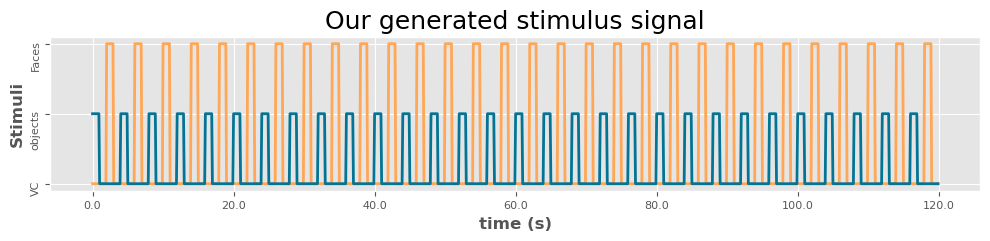

In [56]:
arr_faces = np.zeros(40) # 100msec resolution, to be able to do convolution
arr_faces[20:30] = 1

arr_obj = np.zeros(40) # 100msec resolution, to be able to do convolution
arr_obj[:10] = 0.5

array_faces = np.tile(arr_faces, 30)
array_objects = np.tile(arr_obj, 30)

plt.rcParams['figure.figsize'] = (12, 2) 
plt.plot(array_faces, color = 'xkcd:pale orange')
plt.plot(array_objects, color = 'xkcd:sea blue')
plt.xticks([0,200,400,600,800,1000,1200], ['0.0', '20.0','40.0', '60.0','80.0','100.0', '120.0'])
plt.yticks([0.0, 0.5, 1.0], ['VC', 'objects', 'Faces'], rotation=90)
plt.xlabel("time (s)")
plt.ylabel("Stimuli")
plt.title("Our generated stimulus signal")

# Step 2
- The brain has a delayed hemodynamic response to events that have a particular
shape, so we will need to convolve these events with an appropriate HRF function.
Code from scratch the definition of the HRF function considering the double-gamma
definition (seen in class) and convolve the time course with the following HRF
function [1]: 

$$ h(t) = A( \frac{t^{\alpha_{1}-1} \beta^{\alpha_{1}}_{1} e^{- \beta_{1} t}}{\Gamma{\alpha_{1}}} - c \frac{t^{\alpha_{2}-1} \beta^{\alpha_{2}}_{2} e^{- \beta_{2} t}}{\Gamma{\alpha_{2}}})$$

- Where α = 6, $\alpha_{2}$= 16, $\beta_{1}$ and $\beta_{2}$= 1 and c=⅙. Here, Γ stands for the gamma function. A
is the amplitude of the HRF (which in the case of the GLM is what you try to recover
through model fitting!). You can use both the mathematical definition above or the library ```scipy.stats``` to
generate the gamma distribution.


In [58]:
class hemodynamics():
    '''
    A class that has useful methods for handling hemodynamic response functions

    ...

    Methods
    -------
    hrf(self, alpha1, alpha2, beta1, beta2, c, t, A)
        Calculates the hemodynamic response function of a signal
    
    hrf_plotter(h, alpha1, alpha2)
        plots our hemodynamic response function signal dependent on alpha values
        
    '''

    def __init__(self):
        """
        Constructs all the necessary attributes for the hemodynamics object.

        Attributes
        ----------
            b1 : str
                beta1 constant used in hemodynamic response function
            b2 : str
                beta2 constant used in hemodynamic response function
            c : int
                c constant used in hemodynamic response function
        """
        self.b1 = 1
        self.b2 = 1
        self.c = 1/6

    def hrf(self, t, a1, a2, A):
        '''
        Calculates the hemodynamic response function of a signal

        :param a1:
        :param a2:
        :param b1:
        :param b2:
        :param c: 
        :param t: time
        :param A: amplitude
        
        :returns: the hemodynamic response function
        '''
        h = A * ((t**(a1 - 1) * self.b1**a1 * np.exp(-self.b1 * t))/gamma(a1) -
            self.c * (t**(a2 - 1) * self.b2**a2 * np.exp(-self.b2 * t)) / gamma(a2))
        return h

    def hrf_plotter(self, t, h, alpha1, alpha2, noise = False):
        '''
        plots our hemodynamic response function signal dependent on alpha values

        :param h: an array sequence that contains the hemodynamic signal
        :param t: time array
        :param h: hemodynamic response
        :param alpha1:
        :param alpha2:
        
        :returns: n/a
        '''
        # need to get x_ticks correct regardless of array size
        one = len(h)/3
        two = one*2
        three = one*3

        # plotting
        plt.rcParams['figure.figsize'] = (12, 2)
        plt.title("Hemodynamic Response function at α1: {} and α2: {}".format(alpha1, alpha2))
        plt.xlabel("time (s)")
        plt.ylabel("BOLD Signal [amplitude]")
        plt.xticks()
        plt.yticks()
        if not noise:
            plt.plot(t,h, label='HRF Signal')
        if noise:
            h_noisy = h + np.random.normal(0, 0.15, len(h))
            plt.plot(t, h_noisy, label='HRF w/ Noise, σ=0.15')
            plt.legend()
            return h_noisy


    
    def hrf_alpha_plotter(self,t,alpha1, alpha2,A,alpha_value,upper,lower,jump):
        '''
        plots our hemodynamic response function signal dependent at multiple alpha values on the same plot

        :param t: time array
        :param alpha1: hrf 
        :param alpha2:
        :param A: amplitude
        :param alpha_value: input 1 or 2 to choose variability
        :param upper: upper limit of for loop
        :param lower: lower limit of for loop
        :param jump: jump variable in for loop
        
        :returns: n/a
        '''
        fig, ax = plt.subplots(figsize = (10, 5))
        for a in range(lower,upper,jump):
            if alpha_value == 1:
                ax.plot(t, self.hrf(t, a, alpha2, A), label=a)
            if alpha_value == 2:
                ax.plot(t, self.hrf(t, alpha1, a, A), label=a)
        ax.set_xlabel("time (s)")
        ax.set_ylabel('BOLD Signal [amplitude]')
        ax.set_title('Hemodynamic Response function at different α{} levels'.format(alpha_value))
        ax.grid(True)
        ax.legend(title='α{} values'.format(alpha_value))

    def multi_plot(self, stimulus, hemodynamicResponseFunction, convolution, linecolor='xkcd:pale orange'):
        '''
        Makes a nice multi plot of the convolving process

        :param stimulus: stimulus or any arbitrary signal meant to distinguish vision control, faces, & objects
        :param hemodynamicResponseFunction: hrf double gamma curve
        :param convolution: convolution of stimulus and hrf
        :param title: title of plot
        
        :returns: n/a
        '''
        plt.figure(figsize=(15, 8))
        plt.subplot2grid((3, 3), (0, 0), colspan=2)
        plt.plot(stimulus, '-',color=linecolor)
        plt.xticks([0,200,400,600,800,1000,1200], ['0.0', '20.0','40.0', '60.0','80.0','100.0','120.0'])
        plt.ylabel('Signal', fontsize=15)
        plt.xlabel('Time (seconds)', fontsize=15)
        plt.yticks([0.0, 0.5, 1.0], ['VC', 'objects', 'Faces'], rotation=90)
        plt.title('Stimulus events', fontsize=20)
        plt.grid()

        # right plot -  hrf
        plt.subplot2grid((3, 3), (0, 2), rowspan=2)
        plt.plot(hemodynamicResponseFunction, '.',color=linecolor)
        plt.title('Hemodynamic Response Function', fontsize=20)
        plt.ylabel("BOLD Signal [amplitude]")
        plt.xlabel("Time (seconds)", fontsize=15)
        plt.xticks([0,100,200,300], ['0.0', '10.0','20.0', '30.0'])
        plt.grid()

        # bottom left plot, convolved signal
        plt.subplot2grid((3, 3), (1, 0), colspan=2)
        plt.plot(convolution, '-.', color=linecolor)
        plt.title('Convolved HRF & stimulus-vector', fontsize=20)
        plt.ylabel("BOLD Signal [amplitude]")
        plt.xlabel('Time (seconds)', fontsize=15)
        plt.xticks([0,200,400,600,800,1000,1200], ['0.0', '20.0','40.0', '60.0','80.0','100.0','120.0'])
        plt.tight_layout()
        plt.grid()

    def ols(self, design, stimulus):
        '''
        Calculates the ordinary least squares

        :param design: design matrix - X
        :paran stimulus: vector of measurements of shape - y
        
        :returns: beta coefficients
        '''
        betas_coeff = inv(design.T @ design) @ design.T @ stimulus
        return betas_coeff
    
    def hypothesis_testing(self, design, stimulus, betas):
        '''
        Calculates the MSE by computing the residuals and also spits out r-squared values

        :param design: design matrix - X
        :paran stimulus: vector of measurements of shape - y
        
        :returns: beta coefficients
        '''

        # Gets the y predicted values
        y_hat = design @ betas
        # Computes the residuals of our model
        residuals = stimulus - y_hat
        # Compute the MSE

        # Hypothesis testing. Gets MSE and R-squared.
        mse = np.mean(residuals ** 2)
        print("MSE of our HRF model is %.3f" % (mse))
        Rsquared = 1 - (np.sum((stimulus - y_hat) ** 2) / np.sum((stimulus - stimulus.mean()) ** 2))
        print("R-squared of our HRF model is %.5f" % (Rsquared))
    

    def voxel_activity(self, faces_amp, objects_amp, extra_param=False):
        '''
        Generates a signal for faces and objects with varying amplitudes

        :param aces_amp: amplitude of faces
        :param objects_amp: amplitude of signal for objects

        :returns: a stimuli signal
        '''
        # print("Voxel w/ Face Amplitudes {} and Object Amplitudes {}".format(faces_amp, objects_amp))
        # Step one: generate stimulus onset
        arr_faces = np.zeros(40) # 100msec resolution, to be able to do convolution
        arr_faces[20:] = 1

        arr_obj = np.zeros(40) # 100msec resolution, to be able to do convolution
        arr_obj[:20] = 1 # this has to be one also (stimulus onset is binary, either you present it or you don't)
        
        array_faces = np.tile(arr_faces, 30)
        array_objects = np.tile(arr_obj, 30)

        
        # Step two: convolute each condition with an HRF of given amplitude. We'll use the standard parameters
        alpha1=6 
        alpha2=16
        
        time_start = 0
        time_stop=30
        t = np.linspace(time_start, time_stop, (time_stop - time_start) * 10) # 100 msec resolution
        # print("time shape {}".format(t.shape))
        
        h_faces = self.hrf(t, alpha1, alpha2, faces_amp)
        signal_faces = np.convolve(array_faces, h_faces)[:array_faces.size]
        # print("faces convolved shape: {}".format(signal_faces.shape))
        
        h_objects = self.hrf(t, alpha1, alpha2, objects_amp)
        signal_objects = np.convolve(array_objects, h_objects)[:array_objects.size]
        # print("objects convolved shape: {}".format(signal_objects.shape))
        
        # Design conditions must have amplitude 1; we use ols to find the actual amplitude
        design_faces = np.convolve(array_faces, self.hrf(t, alpha1, alpha2, 1))[:array_faces.size]
        design_objects = np.convolve(array_objects, self.hrf(t, alpha1, alpha2, 1))[:array_objects.size]
        
        
        clean_signal = signal_faces + signal_objects
        signal = clean_signal + np.random.normal(0,0.15,len(clean_signal))
        # print("signal shape: {}".format(signal.shape))

        self.multi_plot(array_faces, h_faces, signal_faces)
        self.multi_plot(array_objects, h_objects, signal_objects, 'xkcd:sea blue')
        
        # Step three: downsample signal (500msec resolution)
        #sampled_signal = signal[::5]
        #print("downsampled signal shape: {}".format(sampled_signal.shape))
        return signal, design_faces, design_objects

In [59]:
# obtain our time vector
time_start=0
time_stop=30
t = np.linspace(time_start, time_stop, (time_stop - time_start)*10) # 100 msec resolution

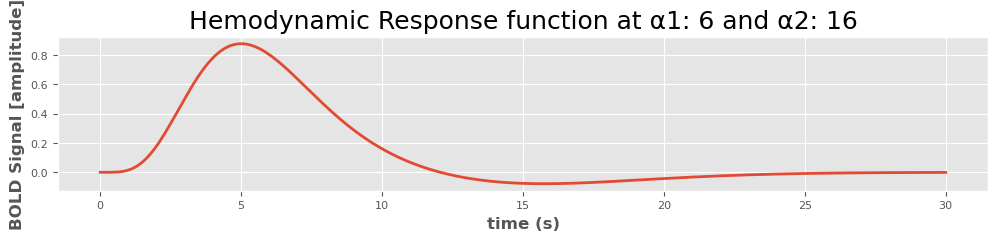

In [60]:
# custom variables 
alpha1=6 
alpha2=16
amplitude = 5

# creates our class object and runs functions
dynamics = hemodynamics()
h = dynamics.hrf(t, alpha1, alpha2, amplitude) # calls the hrf 
dynamics.hrf_plotter(t, h, alpha1, alpha2) # plots results


# Step 3
- Change the HRF function parameters ($ \alpha_{1} $ and $ \alpha_{2} $ ) of the gamma distributions to
obtain slightly different shapes and perform comparisons.

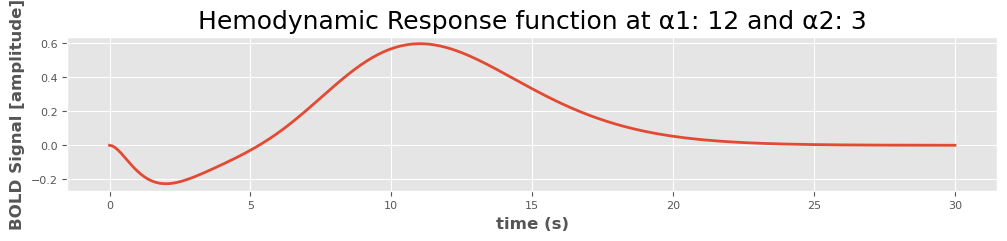

In [61]:
# values to play around with to get individual plots
alpha1 = 12 
alpha2 = 3

h = dynamics.hrf(t, alpha1, alpha2, amplitude) # calls the hrf 
dynamics.hrf_plotter(t, h, alpha1, alpha2)

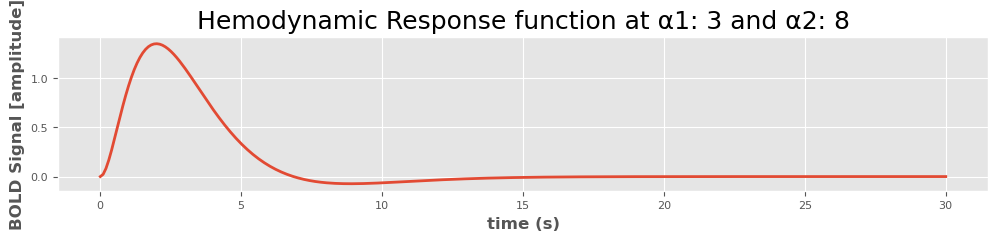

In [62]:
# values to play around with to get individual plots
alpha1 = 3 
alpha2 = 8

# call class methods
h = dynamics.hrf(t, alpha1, alpha2, amplitude) # calls the hrf 
dynamics.hrf_plotter(t, h, alpha1, alpha2)

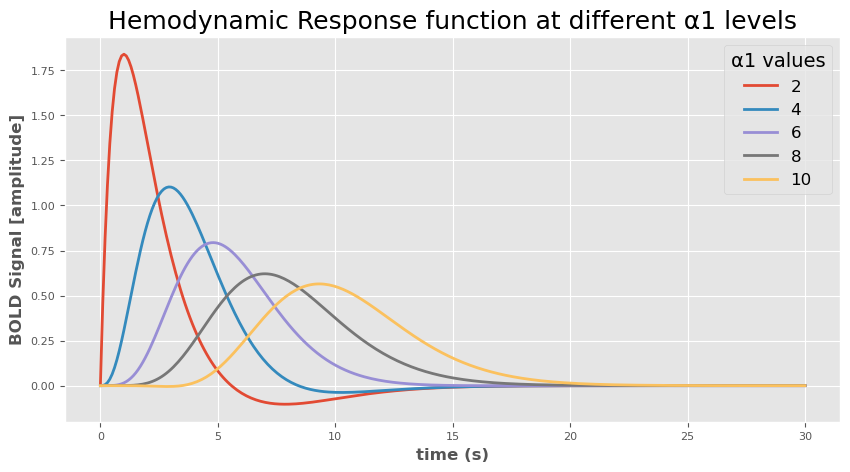

In [63]:
# produce graphs for varying levels of alpha1 
lower = 2
upper = 12
jump = 2

# call automated method that takes hrf of lower to upper limits with the multi line plot to compare effects of alpha values
dynamics.hrf_alpha_plotter(t, alpha1, alpha2, amplitude, 1, upper, lower, jump)

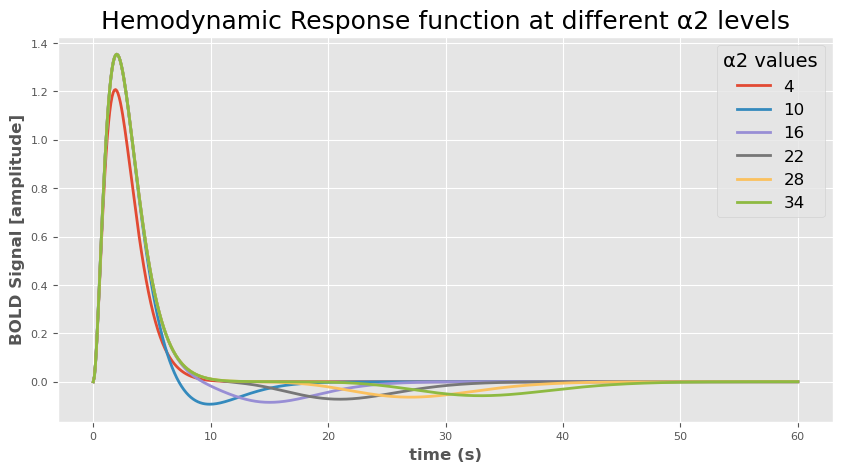

In [64]:
# produce graphs for varying levels of alpha12
lower = 4
upper = 35
jump = 6

# to capture the gamma function dip we need to change the timescale
time_start=0
time_stop=60
t = np.linspace(time_start, time_stop, (time_stop - time_start)*10) # 100 msec resolution

# call automated method that takes hrf of lower to upper limits with the multi line plot to compare effects of alpha values
dynamics.hrf_alpha_plotter(t, alpha1, alpha2, amplitude, 2, upper, lower, jump)

# Step 4

- ln reality, the data is much noisier and the noise comes from low-frequency drift,
autocorrelation, or possibly some aliased physiological artefacts. Choose any HRF. model and add Gaussian noise with a sigma of 0.15. The goal of this part is to
generate simulated activity from a voxel.

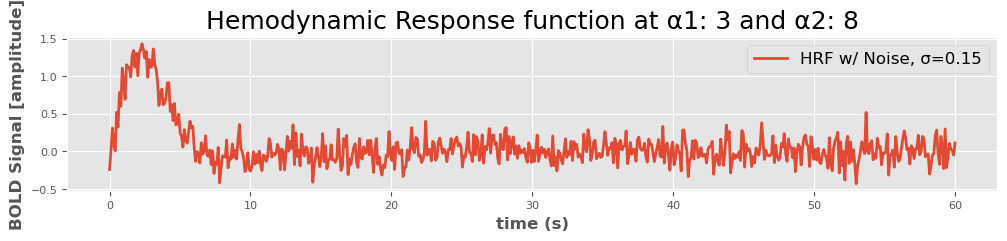

In [65]:
h = dynamics.hrf(t, alpha1, alpha2, amplitude)
h_noisy = dynamics.hrf_plotter(t,h,alpha1,alpha2,True)

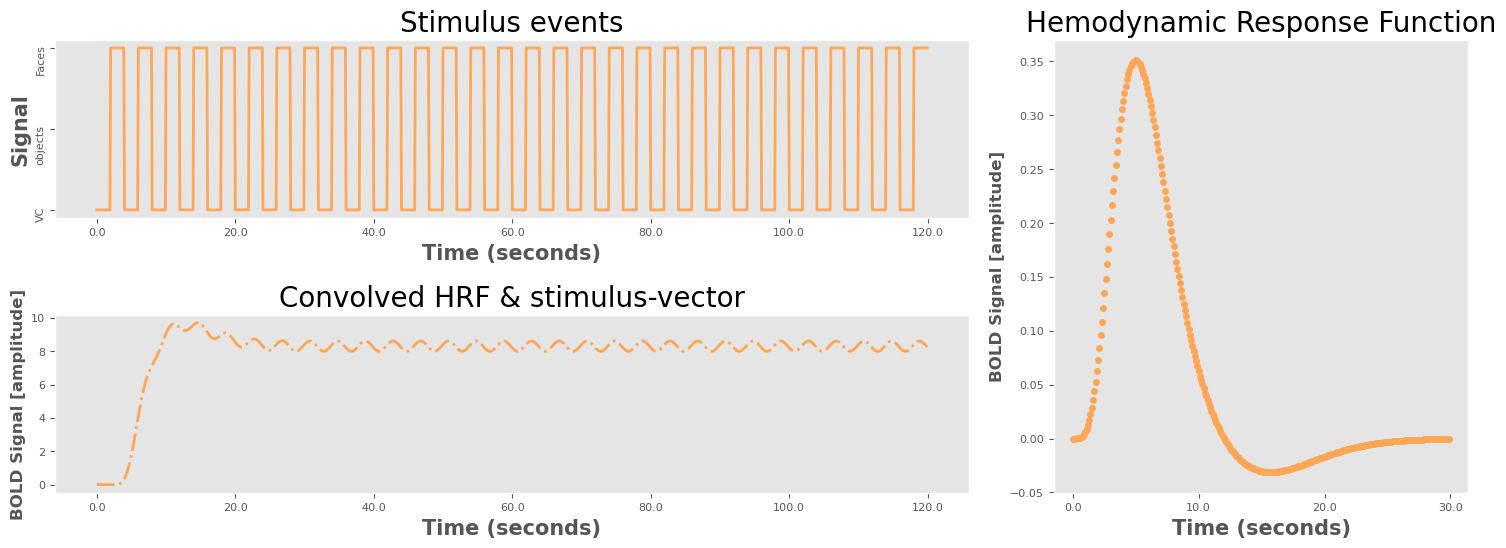

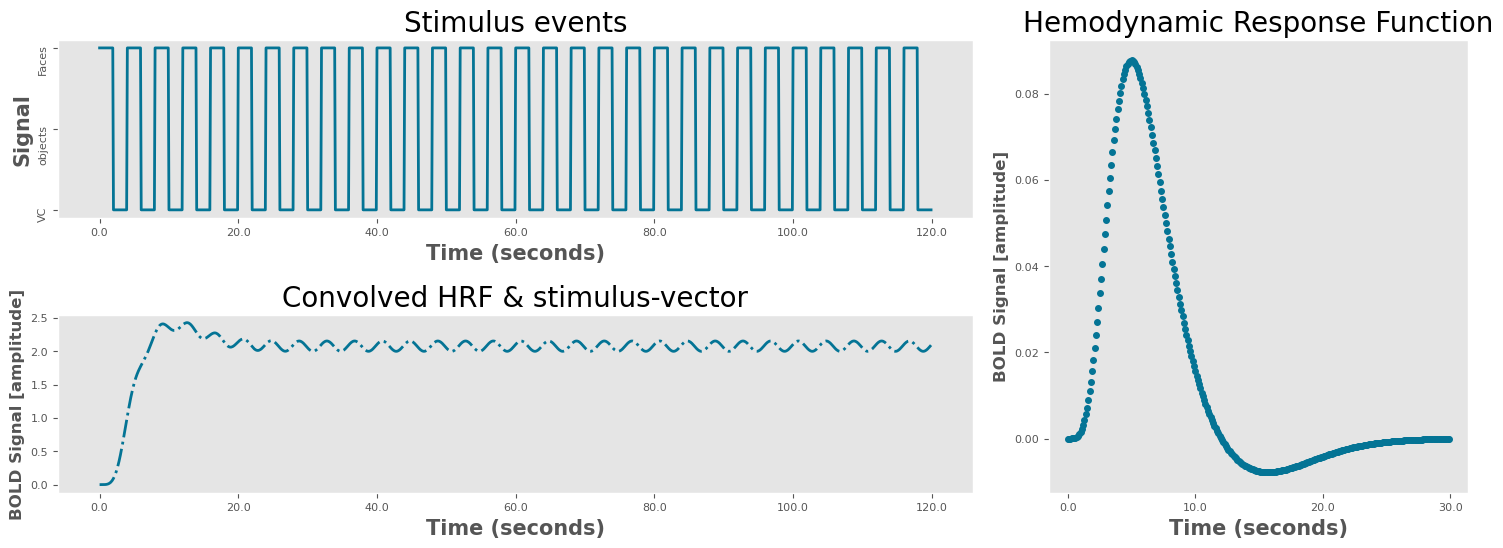

In [66]:
# obtains two voxels of different signals
voxel_1, convolved_faces, convolved_objects  = dynamics.voxel_activity(2.0, 0.5)
#voxel_2 = dynamics.voxel_activity(0.5, 2.0)

# Step 5
- Recover the original signal using a general linear model in the form of: 𝑌 = 𝑋β + ϵ
, where 𝑌 is our observed voxel time series, 𝑋 is our model or design matrix, and is
where we will specify a predicted response to each condition. β is a vector of values
that we will estimate to scale our model and ϵ is independent Gaussian noise. Build a
design matrix 𝑋 using an intercept, and a regressor indicating the onset of each
condition, convolved with the hemodynamic response function (HRF).

In [67]:
# We create our Design Matrix. We must include a constant vector of just 1's to get additional regressor
x_constant = np.ones(1200)
X = np.column_stack((convolved_faces, convolved_objects, x_constant))
y = voxel_1 
print("shape of design matrix (X): {}".format(X.shape))
print("shape of original convolved signal (y): {}".format(y.shape))

shape of design matrix (X): (1200, 3)
shape of original convolved signal (y): (1200,)


# Step 6

- Estimate β using the Ordinary Least Squares (OLS) estimator. Quantify the degree to
which your model is accurately predicting the observed data by calculating the
residual 𝑟𝑒𝑠𝑖𝑑𝑢𝑎𝑙 = 𝑌 − 𝑌. 

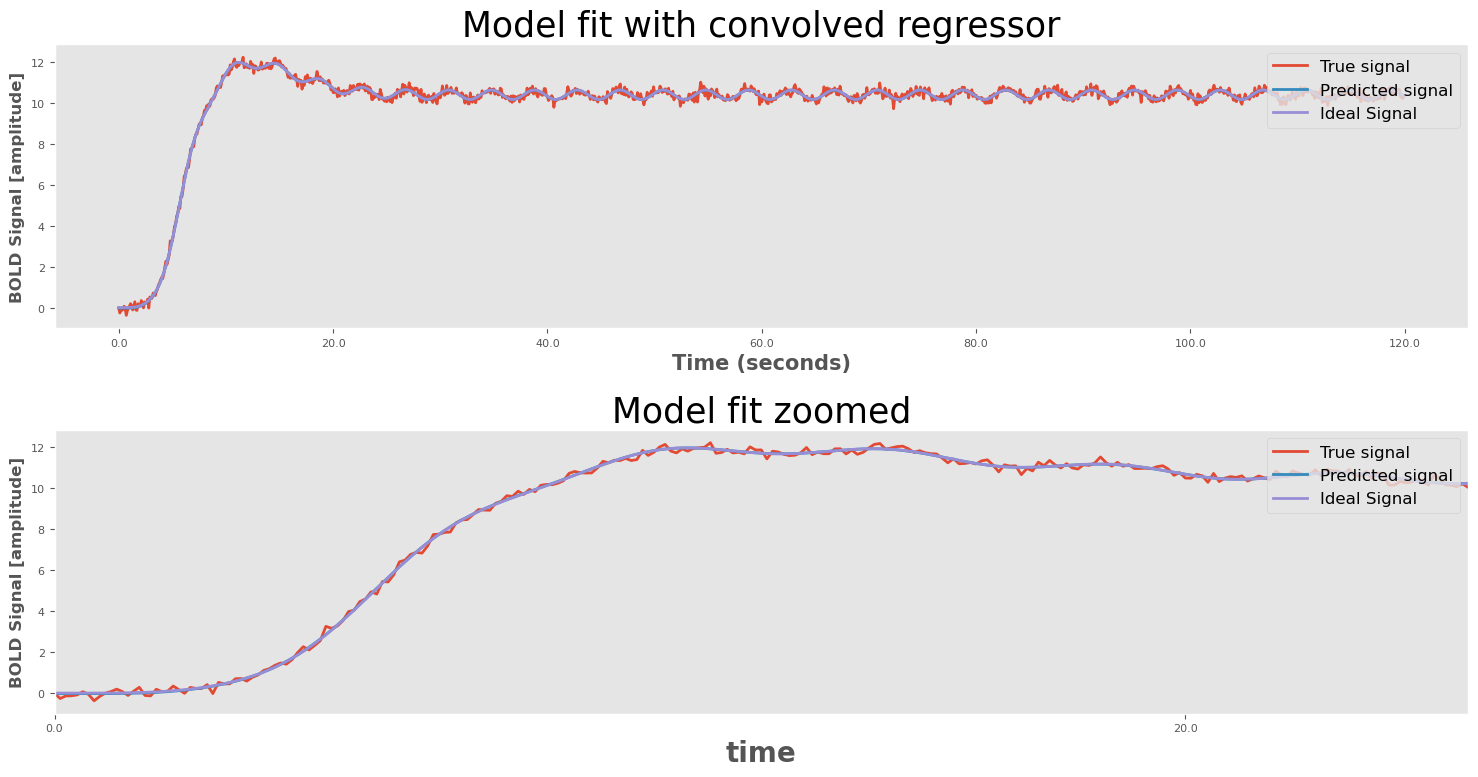

In [68]:
# Call ordinary least squares to obtain our original signal
betas_coeff = dynamics.ols(X,y)
plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(y)
plt.plot(X @ betas_coeff, lw=2)
plt.plot(X @ [2.0, 0.5, 0])
plt.ylabel("BOLD Signal [amplitude]")
plt.xlabel('Time (seconds)', fontsize=15)
plt.xticks([0,200,400,600,800,1000,1200], ['0.0', '20.0','40.0', '60.0','80.0','100.0','120.0'])
plt.title("Model fit with convolved regressor", fontsize=25)
plt.legend(['True signal', 'Predicted signal', 'Ideal Signal'], fontsize=12, loc='upper right')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(y)
plt.plot(X @ betas_coeff, lw=2)
plt.plot(X @ [2.0, 0.5, 0])
plt.ylabel("BOLD Signal [amplitude]")
plt.xlabel('Time (seconds)', fontsize=15)
plt.xticks([0,200,400,600,800,1000,1200], ['0.0', '20.0','40.0', '60.0','80.0','100.0','120.0'])
plt.title("Model fit zoomed", fontsize=25)
plt.legend(['True signal', 'Predicted signal', 'Ideal Signal'], fontsize=12, loc='upper right')
plt.grid()
plt.xlim([0,250])
plt.xlabel("time", fontsize=20)

plt.tight_layout()
plt.show()

##### we also print out the regressors $ \beta_{0}, \beta_{1} ... \beta_{n}$

In [69]:
print(betas_coeff)

[ 1.99034004  0.51535443 -0.02650988]


# Step 7

- Perform a hypothesis test to evaluate if any of the regressors are statistically different
from zero.

MSE of our HRF model is 0.023
R-squared of our HRF model is 0.99487
Calculated betas: [0.10584698 0.01161033 0.01372406]
Measured t: 4.326586250565294


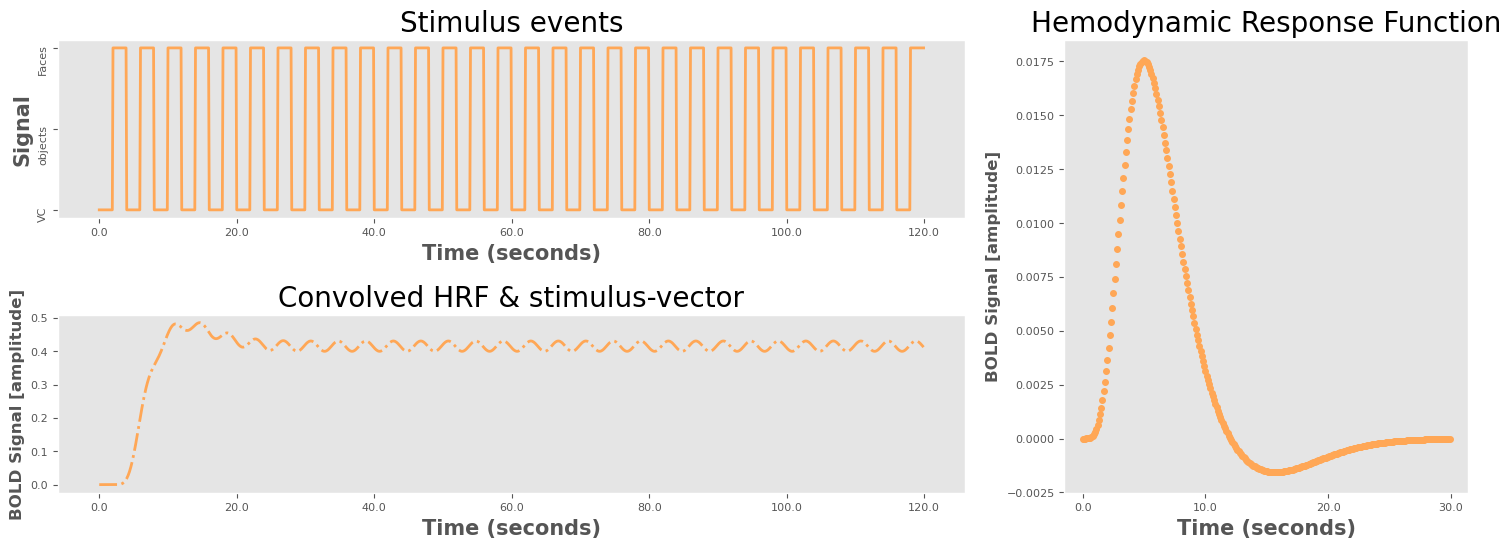

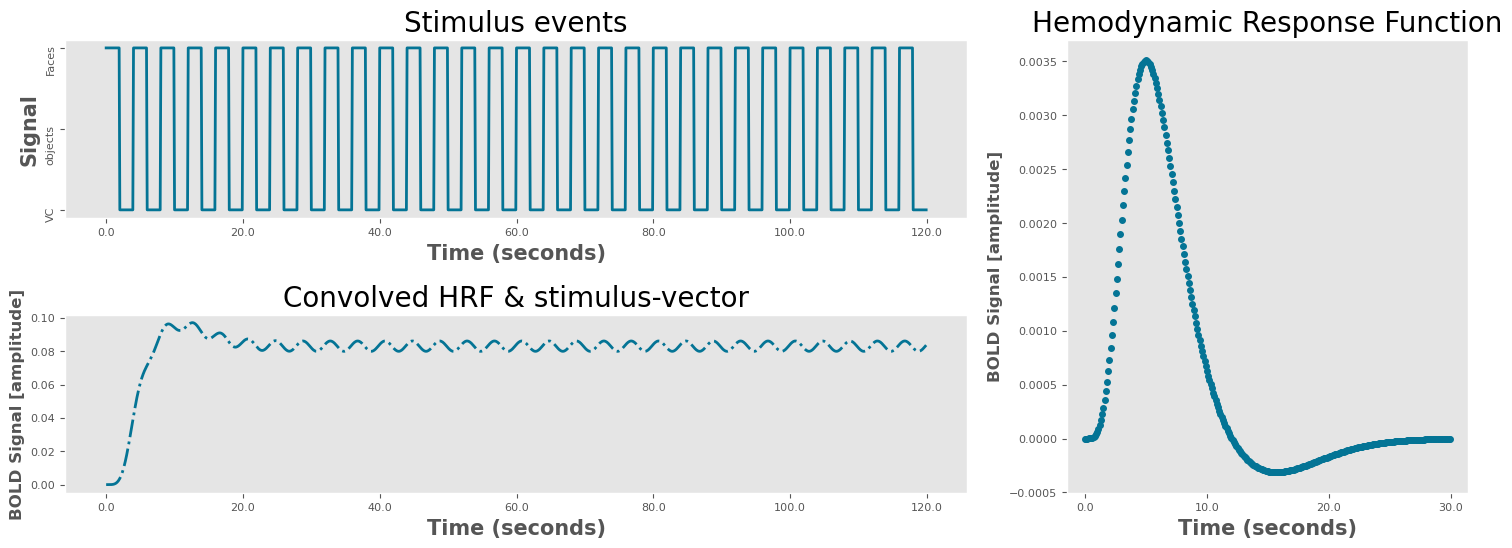

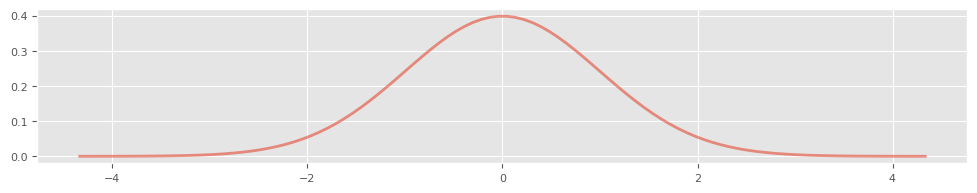

p-value: 1.0355774237136295e-05


In [70]:
# currently we compute the residuals and print out the mse and calcuate R^2 for model fit
from scipy.stats import t
dynamics.hypothesis_testing(X, y, betas_coeff)

# Statistical Hypothesis Testing
voxel_1, convolved_faces, convolved_objects  = dynamics.voxel_activity(0.1, 0.02)
x_constant = np.ones(1200)
X = np.column_stack((convolved_faces, convolved_objects, x_constant))
y = voxel_1
betas_coeff = dynamics.ols(X,y)
print("Calculated betas:", betas_coeff)
# Step one: Calculate t bar
e_bar = y - X @ betas_coeff
sigma2 = e_bar @ e_bar / (240 - 3)  # 240 scans, 3 regressors
c = np.array([1,0,0])
t_bar = (c @ betas_coeff) / np.sqrt((sigma2 * c @ inv(X.transpose() @ X) @ c))
print("Measured t:", t_bar)

# Step two: Generate t-distribution
fig, ax = plt.subplots(1, 1)
df = 300 - 3
x = np.linspace(t.ppf(0.00001, df),t.ppf(0.99999, df), 100)
ax.plot(x, t.pdf(x, df), lw=2, alpha=0.6, label='t pdf')
plt.show()

# Step three: Calculate p-value (one-tailed t test)
p = 1 - t.cdf(t_bar, df)
print("p-value:", p)

# Step 8

- Show a graphical representation of the design matrix and the contrast between the
face and object condition.

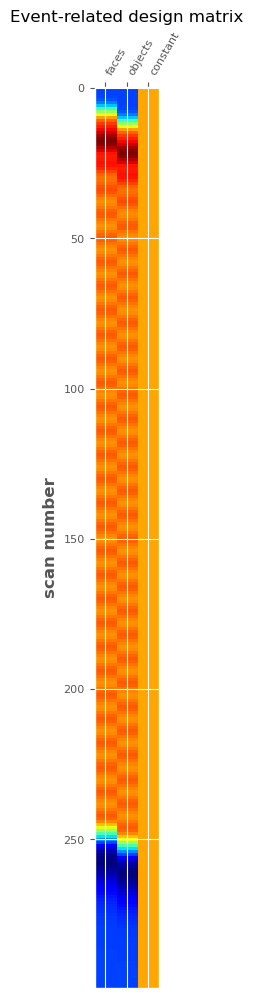

In [18]:
# A Event related matrix 

tr = 0.5 # repetition time is 0.5 seconds
n_scans = 150 * 2  # the acquisition comprises 300 scans (150 sec * 2 per sec)
frame_times = np.arange(n_scans) * tr  # here are the corresponding frame times

# these are the types of the different trials
conditions = np.tile(np.array(['faces','objects']),30)
duration = np.ones(60) * 2
# these are the corresponding onset times
onsets = np.arange(0,120,2)

events = pd.DataFrame({'trial_type': conditions, 'onset': onsets,
                       'duration': duration})

hrf_model = 'glover'
X1 = make_first_level_design_matrix(
    frame_times, events, drift_model=None, hrf_model=hrf_model)

from nilearn.plotting import plot_design_matrix
plot_design_matrix(X1)
plt.title('Event-related design matrix', fontsize=12)
plt.show()

# More complex stimuli signals. Instead of blocks, we measure quick stimuli 

- Now we take some more complex signals and try to see if our model works on more sophisticated stimulus signals. All of these processes follow the steps from above.

In [19]:
def voxel_activity(faces_amp, objects_amp, extra_param=False):
        '''
        Generates a signal for faces and objects with varying amplitudes

        :param aces_amp: amplitude of faces
        :param objects_amp: amplitude of signal for objects

        :returns: a stimuli signal
        '''
        print("Voxel w/ Face Amplitudes {} and Object Amplitudes {}".format(faces_amp, objects_amp))
        # Step one: generate stimulus onset
        arr_faces = np.zeros(5000) # 100msec resolution, to be able to do convolution
        random_stimulus_onsets2 = np.random.randint(0, 5000, 15)
        arr_faces[random_stimulus_onsets2] = 4

        arr_objects = np.zeros(5000) # 100msec resolution, to be able to do convolution
        random_stimulus_onsets1 = np.random.randint(0, 5000, 15)
        arr_objects[random_stimulus_onsets1] = 2

        
        # Step two: convolute each condition with an HRF of given amplitude. We'll use the standard parameters
        alpha1=6 
        alpha2=16
        
        time_start = 0
        time_stop=30
        t = np.linspace(time_start, time_stop, (time_stop - time_start) * 10) # 100 msec resolution
        print("time shape {}".format(t.shape))
        
        h_faces = dynamics.hrf(t, alpha1, alpha2, faces_amp)
        signal_faces = np.convolve(arr_faces, h_faces)[:arr_faces.size]
        print("faces convolved shape: {}".format(signal_faces.shape))
        
        h_objects = dynamics.hrf(t, alpha1, alpha2, objects_amp)
        signal_objects = np.convolve(arr_objects, h_objects)[:arr_objects.size]
        print("objects convolved shape: {}".format(signal_objects.shape))
        
        clean_signal = signal_faces + signal_objects
        signal = clean_signal + np.random.normal(0,0.15,len(clean_signal))
        print("signal shape: {}".format(signal.shape))
        
        # Step three: downsample signal (500msec resolution)
        #sampled_signal = signal[::5]
        #print("downsampled signal shape: {}".format(sampled_signal.shape))
        return signal, signal_faces, signal_objects, arr_faces, arr_objects

(5000,)


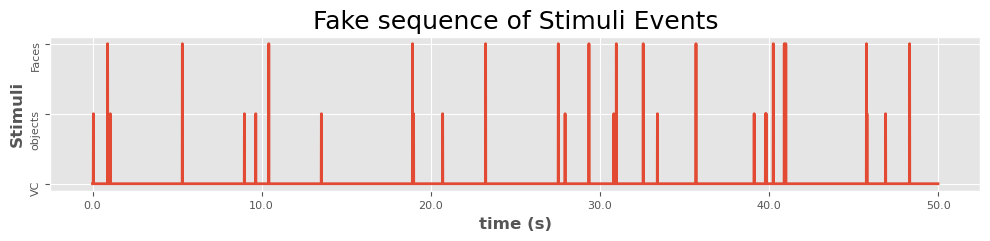

In [20]:
# generating a long repeated sequence
objects = np.random.uniform(0,0, 5000)
random_stimulus_onsets1 = np.random.randint(0, 5000, 15)
objects[random_stimulus_onsets1] = 0.5

faces = np.random.uniform(0,0, 5000)
random_stimulus_onsets2 = np.random.randint(0, 5000, 15)
faces[random_stimulus_onsets2] = 1


signals = np.add(objects, faces)

print(objects.shape)
plotter(signals)

In [21]:
signal, signal_faces, signal_objects, faces_orig_signal, obj_orig_signal = voxel_activity(1,0.5)

Voxel w/ Face Amplitudes 1 and Object Amplitudes 0.5
time shape (300,)
faces convolved shape: (5000,)
objects convolved shape: (5000,)
signal shape: (5000,)


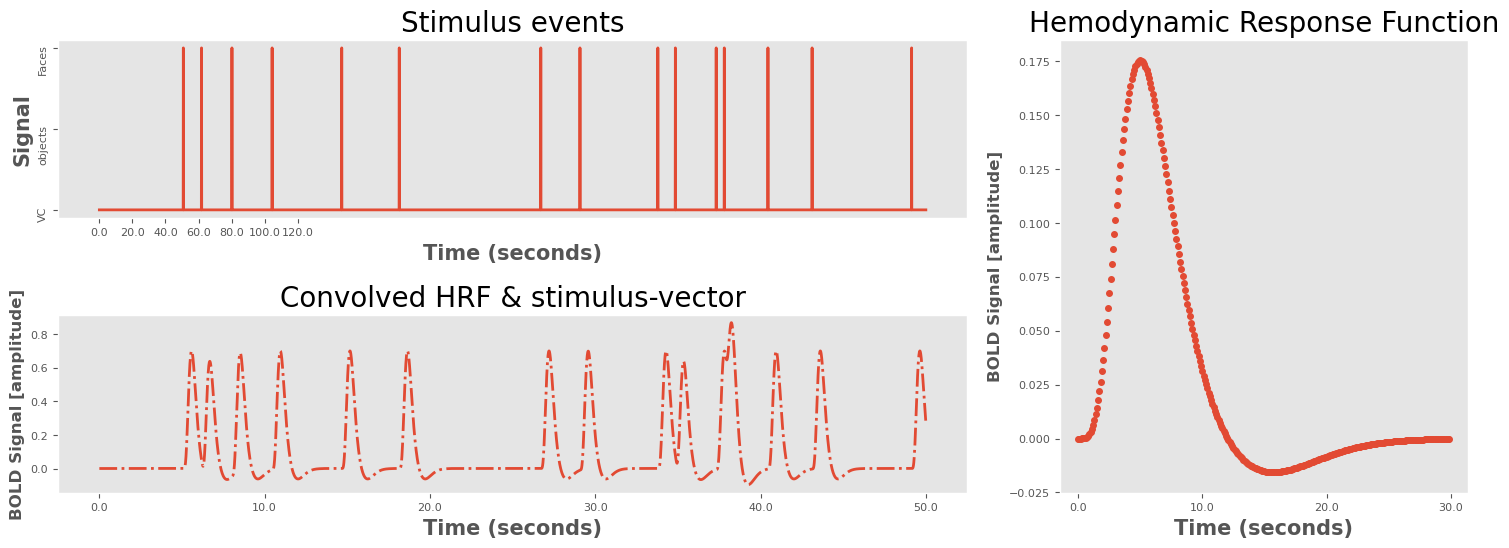

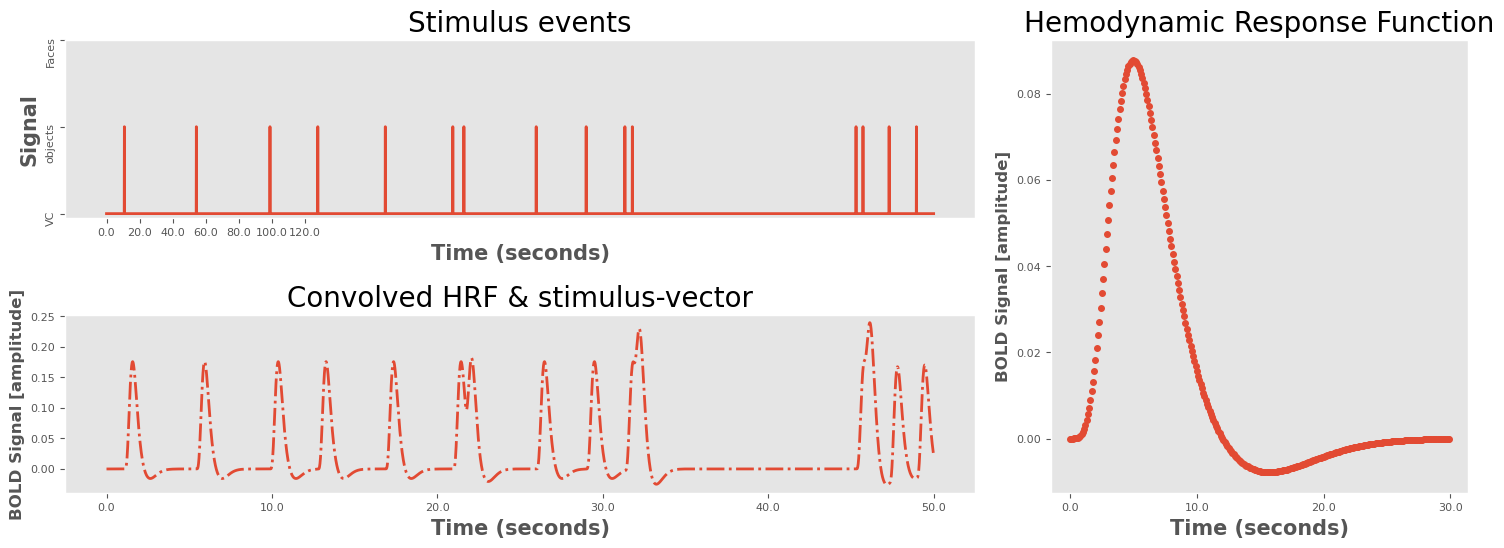

In [22]:
# need original values to make plots
alpha1=6 
alpha2=16

time_start = 0
time_stop=30
t = np.linspace(time_start, time_stop, (time_stop - time_start) * 10) # 100 msec resolution

# Original signals
plt.figure(figsize=(15, 8))
plt.subplot2grid((3, 3), (0, 0), colspan=2)
plt.plot(faces_orig_signal, '-')
plt.xticks([0,200,400,600,800,1000,1200], ['0.0', '20.0','40.0', '60.0','80.0','100.0','120.0'])
plt.ylabel('Signal', fontsize=15)
plt.xlabel('Time (seconds)', fontsize=15)
plt.yticks([0.0, 2.0, 4.0], ['VC', 'objects', 'Faces'], rotation=90)
plt.title('Stimulus events', fontsize=20)
plt.grid()

# right plot -  hrf
hemo = dynamics.hrf(t, alpha1,alpha2, 1)
plt.subplot2grid((3, 3), (0, 2), rowspan=2)
plt.plot(hemo, '.')
plt.title('Hemodynamic Response Function', fontsize=20)
plt.ylabel("BOLD Signal [amplitude]")
plt.xlabel("Time (seconds)", fontsize=15)
plt.xticks([0,100,200,300], ['0.0', '10.0','20.0', '30.0'])
plt.grid()

# bottom left plot, convolved signal
plt.subplot2grid((3, 3), (1, 0), colspan=2)
plt.plot(signal_faces, '-.')
plt.title('Convolved HRF & stimulus-vector', fontsize=20)
plt.ylabel("BOLD Signal [amplitude]")
plt.xlabel('Time (seconds)', fontsize=15)
plt.xticks([0,1000,2000,3000,4000,5000], ['0.0', '10.0','20.0', '30.0','40.0','50.0'])
plt.tight_layout()
plt.grid()
plt.show()

# Original signals
plt.figure(figsize=(15, 8))
plt.subplot2grid((3, 3), (0, 0), colspan=2)
plt.plot(obj_orig_signal, '-')
plt.xticks([0,200,400,600,800,1000,1200], ['0.0', '20.0','40.0', '60.0','80.0','100.0','120.0'])
plt.ylabel('Signal', fontsize=15)
plt.yticks([0.0, 2.0, 4.0], ['VC', 'objects', 'Faces'], rotation=90)
plt.xlabel('Time (seconds)', fontsize=15)
plt.title('Stimulus events', fontsize=20)
plt.grid()

# right plot -  hrf
hemo1 = dynamics.hrf(t, alpha1,alpha2, 0.5)
plt.subplot2grid((3, 3), (0, 2), rowspan=2)
plt.plot(hemo1, '.')
plt.title('Hemodynamic Response Function', fontsize=20)
plt.ylabel("BOLD Signal [amplitude]")
plt.xlabel("Time (seconds)", fontsize=15)
plt.xticks([0,100,200,300], ['0.0', '10.0','20.0', '30.0'])
plt.grid()

# bottom left plot, convolved signal
plt.subplot2grid((3, 3), (1, 0), colspan=2)
plt.plot(signal_objects, '-.')
plt.title('Convolved HRF & stimulus-vector', fontsize=20)
plt.ylabel("BOLD Signal [amplitude]")
plt.xlabel('Time (seconds)', fontsize=15)
plt.xticks([0,1000,2000,3000,4000,5000], ['0.0', '10.0','20.0', '30.0','40.0','50.0'])
plt.tight_layout()
plt.grid()
plt.show()

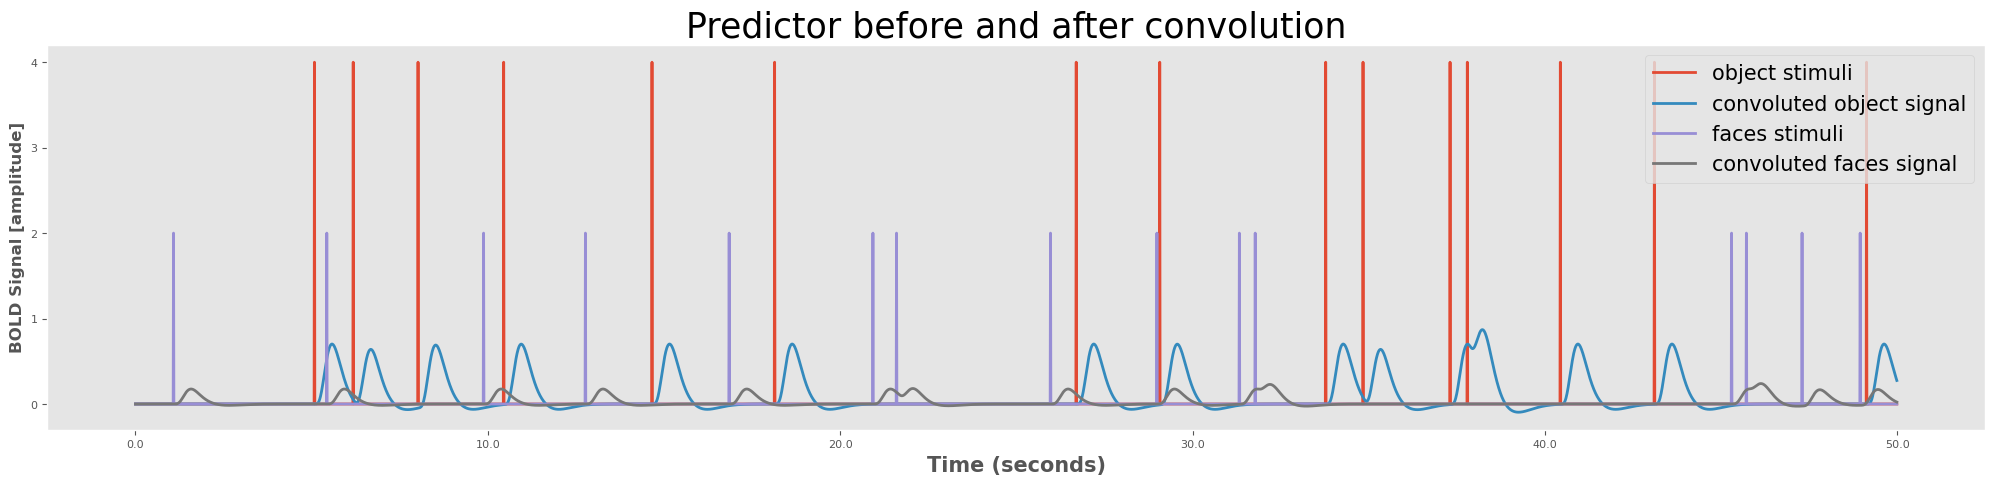

In [23]:
plt.figure(figsize=(25, 5))
plt.plot(faces_orig_signal)
plt.plot(signal_faces)
plt.plot(obj_orig_signal)
plt.plot(signal_objects)
plt.title("Predictor before and after convolution", fontsize=25)
plt.ylabel("BOLD Signal [amplitude]")
plt.xlabel('Time (seconds)', fontsize=15)
plt.legend(['object stimuli', 'convoluted object signal', 'faces stimuli', 'convoluted faces signal'], loc='upper right', fontsize=15)
plt.xticks([0,1000,2000,3000,4000,5000], ['0.0', '10.0','20.0', '30.0','40.0','50.0'])
plt.grid()
plt.show()

[0.98067    0.97909388 0.00135918]


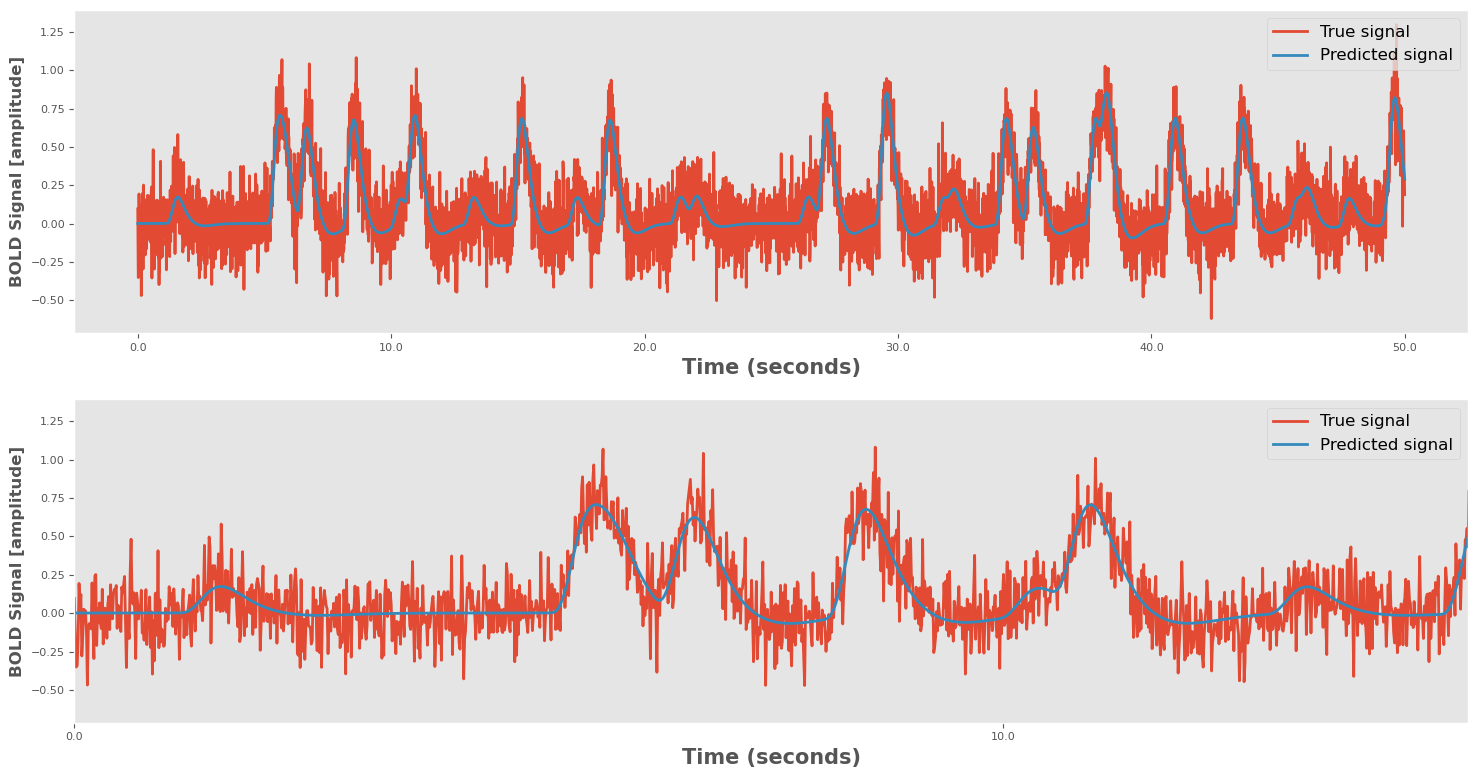

In [24]:
icept = np.ones((signals.size, 1))
objects_conv = signal_objects[:, np.newaxis]
faces_conv = signal_faces[:, np.newaxis]
design_matrix = np.hstack((objects_conv, faces_conv, icept))
betas_coeff = dynamics.ols(design_matrix, signal)
print(betas_coeff)

plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(signal)
plt.plot(design_matrix @ betas_coeff, lw=2)
plt.ylabel("BOLD Signal [amplitude]")
plt.xlabel('Time (seconds)', fontsize=15)
plt.legend(['object stimuli', 'convoluted object signal', 'faces stimuli', 'convoluted faces signal'], loc='upper right', fontsize=15)
plt.xticks([0,1000,2000,3000,4000,5000], ['0.0', '10.0','20.0', '30.0','40.0','50.0'])
plt.legend(['True signal', 'Predicted signal'], fontsize=12, loc='upper right')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(signal)
plt.plot(design_matrix @ betas_coeff, lw=2)
plt.ylabel("BOLD Signal [amplitude]")
plt.xlabel('Time (seconds)', fontsize=15)
plt.legend(['object stimuli', 'convoluted object signal', 'faces stimuli', 'convoluted faces signal'], loc='upper right', fontsize=15)
plt.xticks([0,1000,2000,3000,4000,5000], ['0.0', '10.0','20.0', '30.0','40.0','50.0'])
plt.legend(['True signal', 'Predicted signal'], fontsize=12, loc='upper right')
plt.xlim([0,1500])
plt.grid()

plt.tight_layout()
plt.show()

# Combination of blocks and stimuli

(5000,)


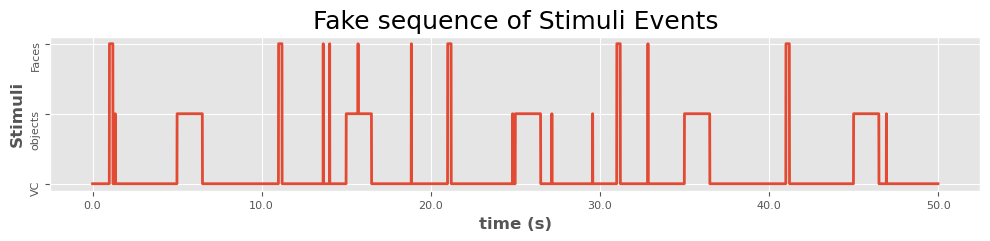

In [25]:
# generating a long repeated sequence
arr = np.zeros(1000)
arr[100:121] = 1
arr[500:650] = 0.5
signal_mix = np.tile(arr, 5)
random_stimulus_onsets2 = np.random.randint(0, len(signal), 5)
signal_mix[random_stimulus_onsets2] = 1
random_stimulus_onsets = np.random.randint(0, len(signal), 6)
signal_mix[random_stimulus_onsets] = 0.5
print(signal_mix.shape)
plotter(signal_mix)

In [26]:
def voxel_activity_3(stimuli, stimuli_amp):
        '''
        Generates a signal for faces and objects with varying amplitudes

        :param aces_amp: amplitude of faces
        :param objects_amp: amplitude of signal for objects

        :returns: a stimuli signal
        '''
        # Step one: generate stimulus onset
        # Step two: convolute each condition with an HRF of given amplitude. We'll use the standard parameters
        alpha1=6 
        alpha2=16
        
        time_start = 0
        time_stop=40
        t = np.linspace(time_start, time_stop, (time_stop - time_start) * 10) # 100 msec resolution
        print("time shape {}".format(t.shape))
        
        h_faces = dynamics.hrf(t, alpha1, alpha2, stimuli_amp)
        signal_faces = np.convolve(stimuli, h_faces)[:stimuli.size]
        print("faces convolved shape: {}".format(signal_faces.shape))
        
        signal = signal_faces + np.random.uniform(1.0, 1.5, len(signal_faces))
        print("signal shape: {}".format(signal.shape))
        
        # plot 1 - stimulus signal
        plt.plot(stimuli)
        plt.title("Voxel Stimulus")
        plt.xlabel('Time (seconds)', fontsize=15)
        plt.ylabel('Signal', fontsize=15)
        plt.yticks([0.0, 0.5, 1.0], ['VC', 'objects', 'Faces'], rotation=90)
        plt.xticks([0,1000,2000,3000,4000,5000], ['0.0', '10.0','20.0', '30.0','40.0','50.0'])
        plt.show()
        
        # plot 2 - hrf
        plt.plot(h_faces)
        plt.title("HRF")
        plt.ylabel("BOLD Signal [amplitude]")
        plt.xlabel("Time (seconds)", fontsize=15)
        plt.xticks([0,100,200,300,400], ['0.0', '10.0','20.0', '30.0','40.0'])
        plt.show()
        
        # plot 3 - convolution
        plt.plot(signal)
        plt.title("convolved signal with noise")
        plt.ylabel("BOLD Signal [amplitude]")
        plt.xlabel('Time (seconds)', fontsize=15)
        plt.legend(['object stimuli', 'convoluted object signal', 'faces stimuli', 'convoluted faces signal'], loc='upper right', fontsize=15)
        plt.xticks([0,1000,2000,3000,4000,5000], ['0.0', '10.0','20.0', '30.0','40.0','50.0'])
        return signal, signal_faces

time shape (400,)
faces convolved shape: (5000,)
signal shape: (5000,)


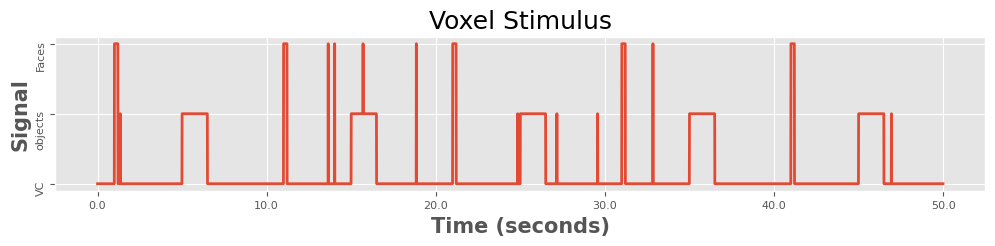

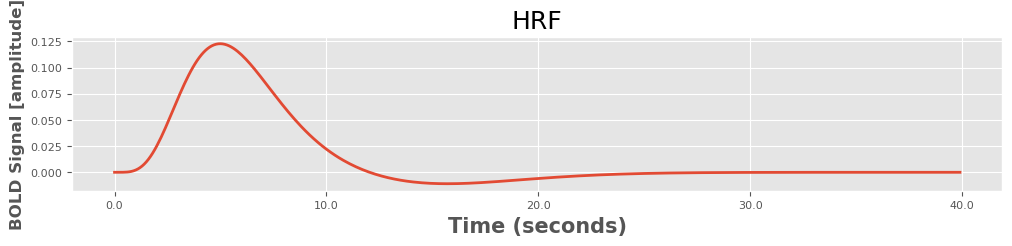

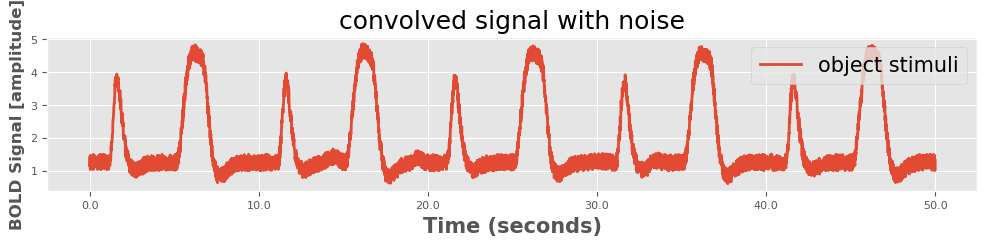

In [27]:
conv_signal_mix, orig_signal_conv = voxel_activity_3(signal_mix, 0.7)

[1.00039461 1.25105464]


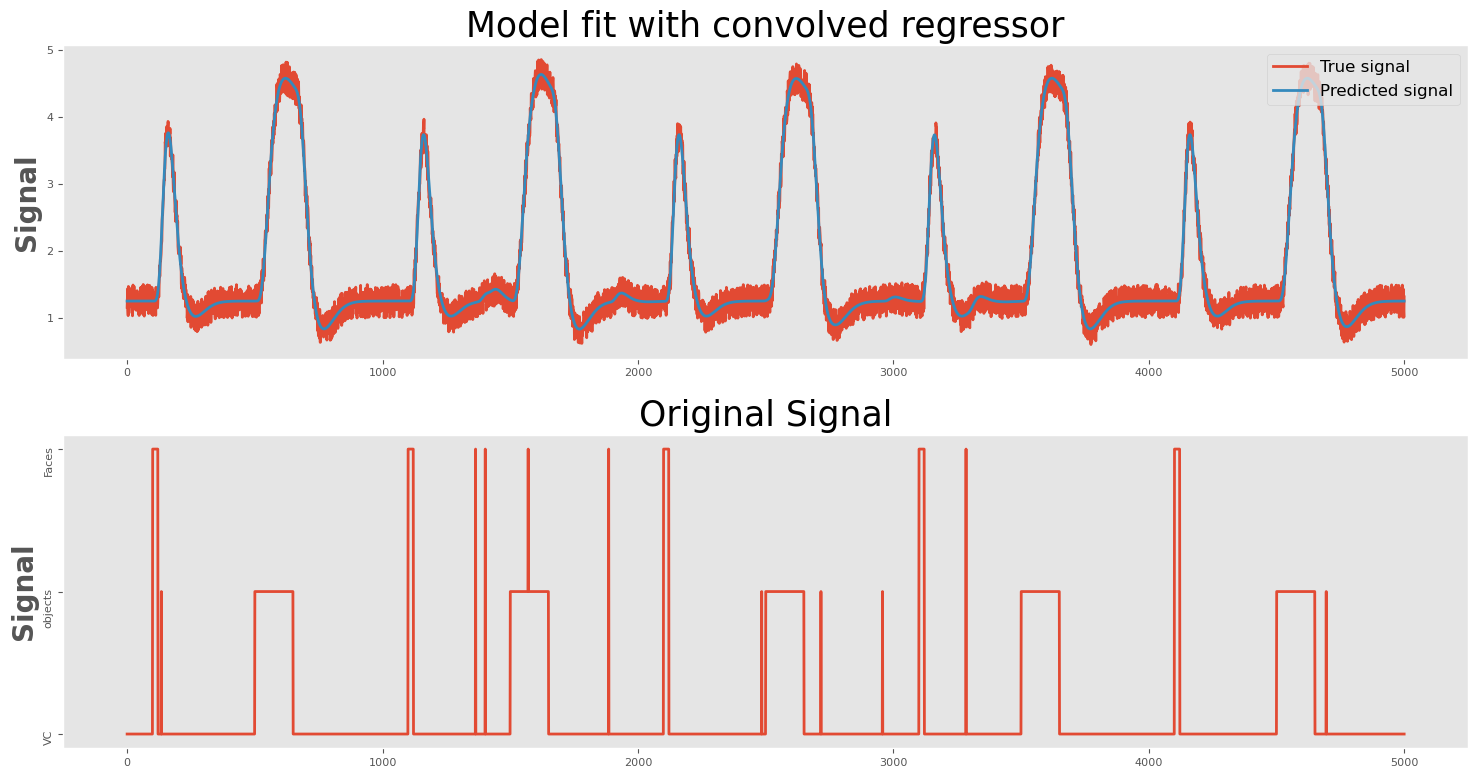

In [28]:
icept = np.ones((signal_mix.size, 1))
faces_conv = orig_signal_conv[:, np.newaxis]
design_matrix2 = np.hstack((faces_conv, icept))
betas_coeff = inv(design_matrix2.T @ design_matrix2) @ design_matrix2.T @ conv_signal_mix
print(betas_coeff)

plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(conv_signal_mix)
plt.plot(design_matrix2 @ betas_coeff, lw=2)
plt.ylabel("Signal", fontsize=20)
plt.title("Model fit with convolved regressor", fontsize=25)
plt.legend(['True signal', 'Predicted signal'], fontsize=12, loc='upper right')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(signal_mix)
plt.ylabel("Signal", fontsize=20)
plt.title("Original Signal", fontsize=25)
plt.grid()
plt.yticks([0.0, 0.5, 1.0], ['VC', 'objects', 'Faces'], rotation=90)
plt.tight_layout()
plt.show()

# Imported Data. Voxel Data 

<function matplotlib.pyplot.title(label, fontdict=None, loc=None, pad=None, *, y=None, **kwargs)>

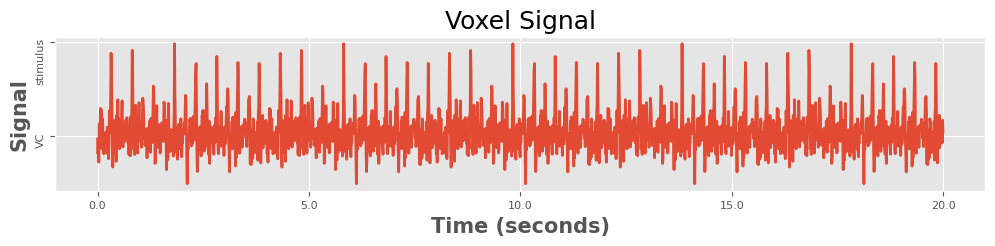

In [29]:

signal = np.load('example_voxel_signal.npy')
signal -= 1000
signals = np.tile(signal, 5)
plt.plot(signals)
plt.title("Voxel Signal")
plt.xlabel('Time (seconds)', fontsize=15)
plt.ylabel('Signal', fontsize=15)
plt.yticks([0.0, 15], ['VC', 'stimulus'], rotation=90)
plt.xticks([0,500,1000,1500,2000], ['0.0', '5.0','10.0', '15.0','20.0'])
plt.title

In [30]:
def voxel_activity_2(faces, faces_amp):
        '''
        Generates a signal for faces and objects with varying amplitudes

        :param aces_amp: amplitude of faces
        :param objects_amp: amplitude of signal for objects

        :returns: a stimuli signal
        '''
        # Step one: generate stimulus onset
        
        # Step two: convolute each condition with an HRF of given amplitude. We'll use the standard parameters
        alpha1=6 
        alpha2=16
        
        time_start = 0
        time_stop=40
        t = np.linspace(time_start, time_stop, (time_stop - time_start) * 10) # 100 msec resolution
        print("time shape {}".format(t.shape))
        
        h_faces = dynamics.hrf(t, alpha1, alpha2, faces_amp)
        signal_faces = np.convolve(faces, h_faces)[:faces.size]
        print("faces convolved shape: {}".format(signal_faces.shape))
        
        signal = signal_faces + np.random.uniform(1.0, 30.5, len(signal_faces))
        
        # plot 1 - stimulus signal
        plt.plot(faces)
        plt.title("Voxel Stimulus")
        plt.xlabel('Time (seconds)', fontsize=15)
        plt.ylabel('Signal', fontsize=15)
        plt.yticks([0.0, 15], ['VC', 'stimulus'], rotation=90)
        plt.xticks([0,500,1000,1500,2000], ['0.0', '5.0','10.0', '15.0','20.0'])
        plt.show()
        
        # plot 2 - hrf
        plt.plot(h_faces)
        plt.title("HRF")
        plt.ylabel("BOLD Signal [amplitude]")
        plt.xlabel("Time (seconds)", fontsize=15)
        plt.xticks([0,100,200,300,400], ['0.0', '10.0','20.0', '30.0','40.0'])
        plt.show()
        
        # plot 3 - convolution
        plt.plot(signal)
        plt.title("convolved signal with noise")
        plt.ylabel("BOLD Signal [amplitude]")
        plt.xlabel('Time (seconds)', fontsize=15)
        plt.legend(['object stimuli', 'convoluted object signal', 'faces stimuli', 'convoluted faces signal'], loc='upper right', fontsize=15)
        plt.xticks([0,500,1000,1500,2000], ['0.0', '5.0','10.0', '15.0','20.0'])
        return signal, signal_faces

time shape (400,)
faces convolved shape: (2000,)


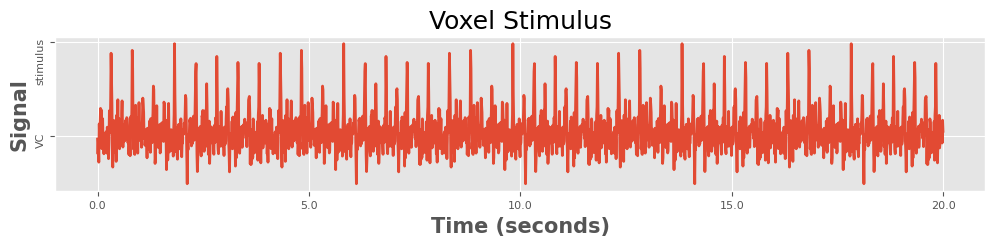

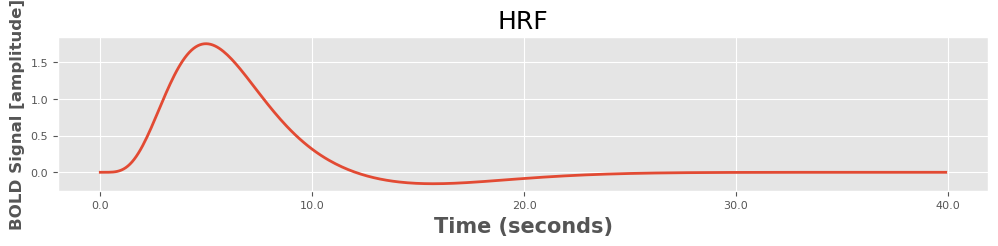

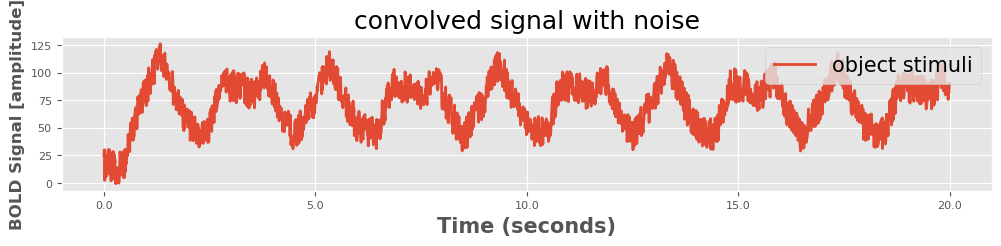

In [31]:
conv_signal, orig_faces = voxel_activity_2(signals, 10)

[ 0.99493798 16.05412194]


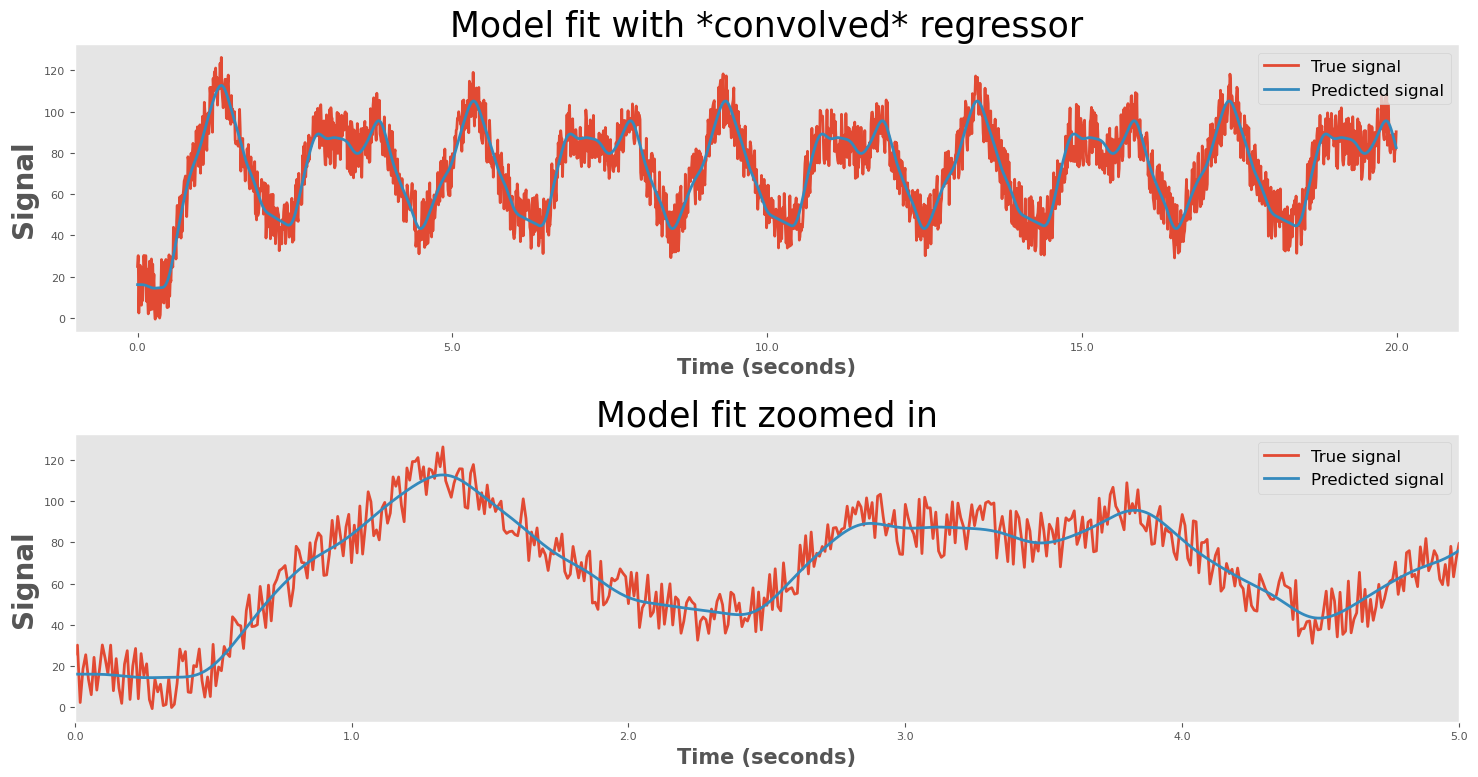

In [32]:
icept = np.ones((signals.size, 1))
faces_conv = orig_faces[:, np.newaxis]
design_matrix2 = np.hstack((faces_conv, icept))
betas_coeff = inv(design_matrix2.T @ design_matrix2) @ design_matrix2.T @ conv_signal
print(betas_coeff)

plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(conv_signal)
plt.plot(design_matrix2 @ betas_coeff, lw=2)
plt.ylabel("Signal", fontsize=20)
plt.title("Model fit with *convolved* regressor", fontsize=25)
plt.legend(['True signal', 'Predicted signal'], fontsize=12, loc='upper right')
plt.xlabel('Time (seconds)', fontsize=15)
plt.xticks([0,500,1000,1500,2000], ['0.0', '5.0','10.0', '15.0','20.0'])
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(conv_signal)
plt.plot(design_matrix2 @ betas_coeff, lw=2)
plt.ylabel("Signal", fontsize=20)
plt.xlim([0,500])
plt.title("Model fit zoomed in", fontsize=25)
plt.legend(['True signal', 'Predicted signal'], fontsize=12, loc='upper right')
plt.xlabel('Time (seconds)', fontsize=15)
plt.xticks([0,100,200,300,400,500], ['0.0', '1.0','2.0', '3.0', '4.0', '5.0'])
plt.grid()

plt.tight_layout()
plt.show()

# Actual Example of Brain 

In [33]:
from nilearn import datasets
n_samples = 20
localizer_dataset = datasets.fetch_localizer_calculation_task(
    n_subjects=n_samples, legacy_format=False)

In [34]:
design_matrix = pd.DataFrame([1] * n_samples, columns=['intercept'])

In [35]:
from nilearn.glm.second_level import SecondLevelModel
second_level_model = SecondLevelModel().fit(
    localizer_dataset.cmaps, design_matrix=design_matrix)

In [36]:
z_map = second_level_model.compute_contrast(output_type='z_score')

/Users/simonlee/opt/anaconda3/envs/NX-421/lib/python3.8/site-packages/nilearn/plotting/img_plotting.py:300: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


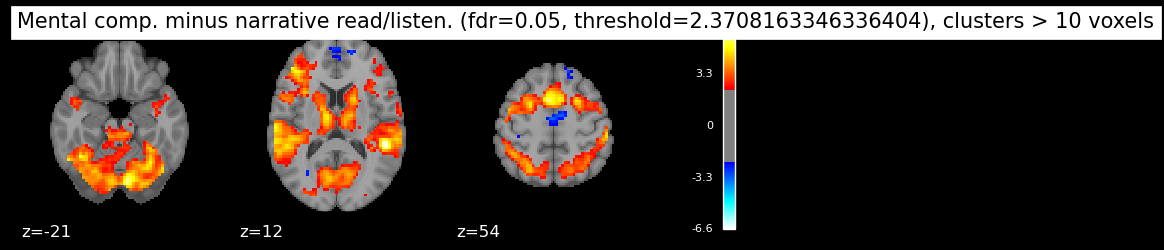

In [37]:
from nilearn.glm import threshold_stats_img
import nibabel as nib
from nilearn.plotting import plot_stat_map
cluster_size = 10 # Fill me with the number of voxels for a cluster to be kept
fdr_rate = 0.05 # Fill me with the fdr rate to use!
clean_map, threshold = threshold_stats_img(z_map, alpha=fdr_rate, height_control='fdr', cluster_threshold=cluster_size)

# Saving it to disk
nib.save(clean_map, 'localizer_population_cleaned_map.nii.gz')

# And this is just to plot here!
plot_stat_map(clean_map, threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Mental comp. minus narrative read/listen. (fdr={}, threshold={}), clusters > {} voxels'.format(fdr_rate, threshold, cluster_size))
plt.show()

# Creating a fake brain slice: 2-D voxel array

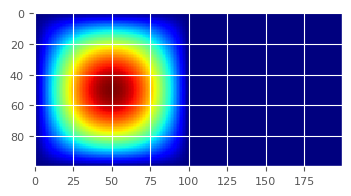

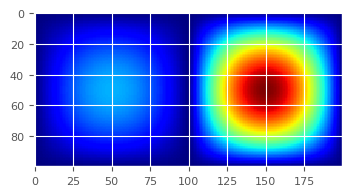

In [38]:
# First, we create a 2-D array contatining face sensitivities
sen_faces = np.zeros((100,200))
for x in range(200):
    for y in range(100):
        sen_faces[y,x] = np.clip(np.sin(np.pi * y / 100) * np.sin(np.pi * 2 * x / 200), 0, 1)
plt.imshow(sen_faces)
plt.show()
# Then, we create a 2-D array contatining object sensitivities
sen_obj = np.zeros((100,200))
for x in range(200):
    for y in range(100):
        sen_obj[y,x] = np.clip(np.sin(np.pi * y / 100) * np.sin(np.pi * 2 * x / 200) * (-1), 0, 1)
        sen_obj[y,x] += np.clip(0.3 * np.sin(np.pi * y / 100) * np.sin(np.pi * 2 * x / 200), 0, 1)
plt.imshow(sen_obj)
plt.show()

In [39]:
def voxel_activity_2d(faces_amp, objects_amp, extra_param=False):
        '''
        Generates a signal for faces and objects with varying amplitudes

        :param aces_amp: amplitude of faces
        :param objects_amp: amplitude of signal for objects

        :returns: a stimuli signal
        '''
        # print("Voxel w/ Face Amplitudes {} and Object Amplitudes {}".format(faces_amp, objects_amp))
        # Step one: generate stimulus onset
        arr_faces = np.zeros(40) # 100msec resolution, to be able to do convolution
        arr_faces[20:] = 1

        arr_obj = np.zeros(40) # 100msec resolution, to be able to do convolution
        arr_obj[:20] = 1 # this has to be one also (stimulus onset is binary, either you present it or you don't)
        
        array_faces = np.tile(arr_faces, 30)
        array_objects = np.tile(arr_obj, 30)

        
        # Step two: convolute each condition with an HRF of given amplitude. We'll use the standard parameters
        alpha1=6 
        alpha2=16
        
        time_start = 0
        time_stop=30
        t = np.linspace(time_start, time_stop, (time_stop - time_start) * 10) # 100 msec resolution
        # print("time shape {}".format(t.shape))
        
        h_faces = dynamics.hrf(t, alpha1, alpha2, faces_amp)
        signal_faces = np.convolve(array_faces, h_faces)[:array_faces.size]
        # print("faces convolved shape: {}".format(signal_faces.shape))
        
        h_objects = dynamics.hrf(t, alpha1, alpha2, objects_amp)
        signal_objects = np.convolve(array_objects, h_objects)[:array_objects.size]
        # print("objects convolved shape: {}".format(signal_objects.shape))
        
        # Design conditions must have amplitude 1; we use ols to find the actual amplitude
        design_faces = np.convolve(array_faces, dynamics.hrf(t, alpha1, alpha2, 1))[:array_faces.size]
        design_objects = np.convolve(array_objects, dynamics.hrf(t, alpha1, alpha2, 1))[:array_objects.size]
        
        
        clean_signal = signal_faces + signal_objects
        signal = clean_signal + np.random.normal(0,0.15,len(clean_signal))
        # print("signal shape: {}".format(signal.shape))

        # self.multi_plot(array_faces, h_faces, signal_faces)
        # self.multi_plot(array_objects, h_objects, signal_objects, 'xkcd:sea blue')
        
        # Step three: downsample signal (500msec resolution)
        #sampled_signal = signal[::5]
        #print("downsampled signal shape: {}".format(sampled_signal.shape))
        return signal, design_faces, design_objects

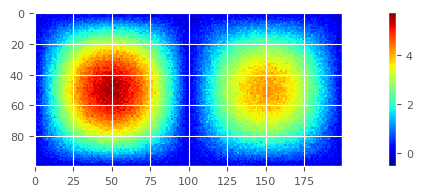

In [40]:
# Now, we can generate voxel signals for each cell
voxel_activations = np.zeros((100,200, 1200))
design_faces = np.zeros((100,200, 1200))
design_objects = np.zeros((100,200, 1200))

for x in range(200):
    for y in range(100):
        voxel_activations[y,x,:], design_faces[y,x,:], design_objects[y,x,:] = voxel_activity_2d(sen_faces[y,x], sen_obj[y,x])
        
plt.imshow(voxel_activations[:,:,500])
plt.colorbar()
plt.show()

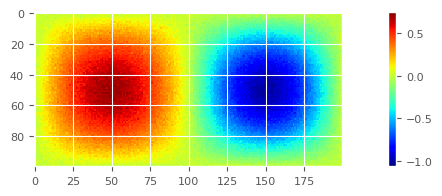

In [41]:
# Finally, we can compute the contrast between the beta coefficients using OLS
betas = np.zeros((100,200,3))
contrast = np.zeros((100,200))
for i in range(200):
    for j in range(100):
        x_constant = np.ones(1200)
        X = np.column_stack((design_faces[j,i,:], design_objects[j,i,:], x_constant))
        betas[j,i,:] = dynamics.ols(X,voxel_activations[j,i,:])
contrast = betas[:,:,0] - betas[:,:,1]
plt.imshow(contrast)
plt.colorbar()
plt.show()

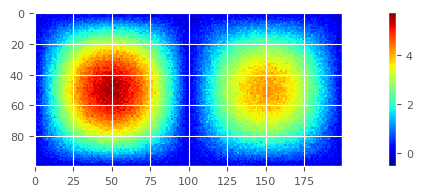

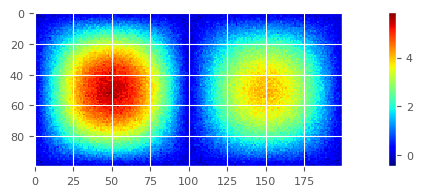

In [42]:
plt.imshow(voxel_activations[:,:,500])
plt.colorbar()
plt.show()

plt.imshow(voxel_activations[:,:,550])
plt.colorbar()
plt.show()

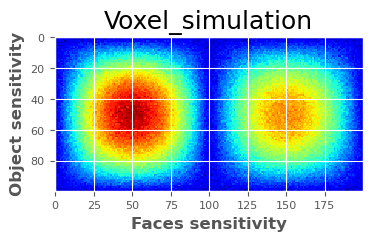

In [43]:
FFMpegWriter = manimation.writers['ffmpeg']
metadata = dict(title='Simulation of voxel activations', artist='Merkourios Simos',
                comment='Left: (Faces, 1),(Objects, 0.3) Right: (Objects, 1)')
writer = FFMpegWriter(fps=24, metadata=metadata)

fig, ax = plt.subplots()
# fig.colorbar(plt.cm.ScalarMappable(), ax=ax)


with writer.saving(fig, "Voxel_simulation.mp4", 100):
    for k in range(600):
        # Create a new plot object
        ax.set_title('Voxel_simulation')
        ax.set_ylabel("Object sensitivity")
        ax.set_xlabel("Faces sensitivity")
        ax.imshow(voxel_activations[:,:,k])
        writer.grab_frame()

# Working with Actual Brain Data

In [74]:
def reset_overlays():
    """
    Clears view and completely remove visualization. All files opened in FSLeyes are closed.
    The view (along with any color map) is reset to the regular ortho panel.
    """
    l = frame.overlayList
    while(len(l)>0):
        del l[0]
    frame.removeViewPanel(frame.viewPanels[0])
    # Put back an ortho panel in our viz for future displays
    frame.addViewPanel(OrthoPanel)
    
def mkdir_no_exist(path):
    if not op.isdir(path):
        os.makedirs(path)
        
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def direct_file_download_open_neuro(file_list, file_types, dataset_id, dataset_version, save_dirs):
    # https://openneuro.org/crn/datasets/ds004226/snapshots/1.0.0/files/sub-001:sub-001_scans.tsv
    for i, n in enumerate(file_list):
        subject = n.split('_')[0]
        download_link = 'https://openneuro.org/crn/datasets/{}/snapshots/{}/files/{}:{}:{}'.format(dataset_id, dataset_version, subject, file_types[i],n)
        print('Attempting download from ', download_link)
        download_url(download_link, op.join(save_dirs[i], n))
        print('Ok')
        
def get_json_from_file(fname):
    f = open(fname)
    data = json.load(f)
    f.close()
    return data

## Loading our dataset

- You will need to manually need to create a folder to store the downloaded data
- e.g. /Users/simonlee/mne_data/

In [46]:
dataset_fmap = 'ds000105'
subject_fmap = '1' 

# Download one subject's data from each dataset
bids_root = op.join(op.dirname(sample.data_path()), dataset_fmap)

mkdir_no_exist(bids_root)

100%|█████████████████████████████████████| 1.65G/1.65G [00:00<00:00, 1.14TB/s]
Untarring contents of '/Users/simonlee/mne_data/MNE-sample-data-processed.tar.gz' to '/Users/simonlee/mne_data'


In [47]:
func_path = op.join(bids_root, 'sub-1', 'func')
anat_path = op.join(bids_root, 'sub-1', 'anat')
mkdir_no_exist(op.join(bids_root, 'sub-1'))
mkdir_no_exist(func_path)
mkdir_no_exist(anat_path)

direct_file_download_open_neuro(file_list=['sub-1_task-objectviewing_run-01_bold.nii.gz', 
                                           'sub-1_T1w.nii.gz'], 
                                file_types=['func', 'anat'], 
                                dataset_id=dataset_fmap, 
                                dataset_version='00001', 
                                save_dirs=[func_path,
                                           func_path,
                                           anat_path,
                                           anat_path])

Attempting download from  https://openneuro.org/crn/datasets/ds000105/snapshots/00001/files/sub-1:func:sub-1_task-objectviewing_run-01_bold.nii.gz


sub-1:func:sub-1_task-objectviewing_run-01_bold.nii.gz: 25.7MB [00:21, 1.17MB/s]


Ok
Attempting download from  https://openneuro.org/crn/datasets/ds000105/snapshots/00001/files/sub-1:anat:sub-1_T1w.nii.gz


sub-1:anat:sub-1_T1w.nii.gz: 5.96MB [00:05, 1.03MB/s]

Ok


In [48]:
print_dir_tree(bids_root, max_depth=4)

|ds000105/
|--- sub-1/
|------ anat/
|------ func/
|--------- sub-1_T1w.nii.gz
|--------- sub-1_task-objectviewing_run-01_bold.nii.gz


In [ ]:
reset_overlays()
load(op.join(bids_root, 'sub-1', 'func', 'sub-1_task-objectviewing_run-01_bold.nii.gz'))

## Loading the Event (Stimuli) Files

In [75]:
direct_file_download_open_neuro(file_list=['sub-1_task-objectviewing_run-01_events.tsv'], 
                                file_types=['func'], 
                                dataset_id=dataset_fmap, 
                                dataset_version='00001', 
                                save_dirs=[func_path])

Attempting download from  https://openneuro.org/crn/datasets/ds000105/snapshots/00001/files/sub-1:func:sub-1_task-objectviewing_run-01_events.tsv


sub-1:func:sub-1_task-objectviewing_run-01_events.tsv: 8.19kB [00:00, 25.2kB/s]

Ok


In [76]:
events = pd.read_csv(op.join(func_path, 'sub-1_task-objectviewing_run-01_events.tsv'), sep='\t')

## First Level General Linear Model

In [77]:
fmri_data = op.join(bids_root, 'sub-1', 'func', 'sub-1_task-objectviewing_run-01_bold.nii.gz')

In [78]:
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel

# Specify what sort of GLM we want (nature of the noise, repetition time of the data and other parameters)
fmri_glm = FirstLevelModel(t_r=2.5,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model='cosine',
                           high_pass=.01)

# Fit the model to our design and data
fmri_glm = fmri_glm.fit(fmri_data, events)

## Creating our design matrix

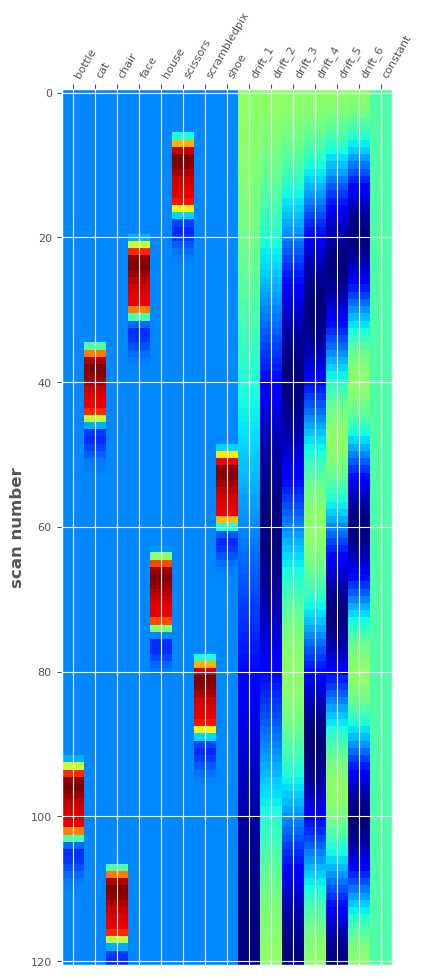

In [79]:
from nilearn.plotting import plot_design_matrix
%matplotlib inline
plot_design_matrix(fmri_glm.design_matrices_[0])
plt.show()

## Contrast Matrix

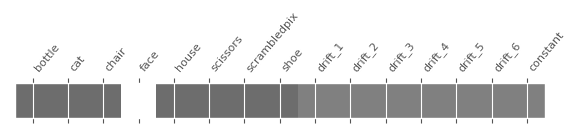

In [80]:
from nilearn.plotting import plot_contrast_matrix
contrast = [-1/7, -1/7, -1/7, 1, -1/7, -1/7, -1/7, -1/7, 0, 0, 0, 0, 0, 0, 0]
plot_contrast_matrix(contrast, design_matrix=fmri_glm.design_matrices_[0])
plt.show()

## Raw Z-scores

In [81]:
import nibabel as nib
import numpy as np
z_map = fmri_glm.compute_contrast(np.array(contrast).transpose(),
                                  output_type='z_score')

nib.save(z_map, 'z_map_uncorrected.nii.gz')

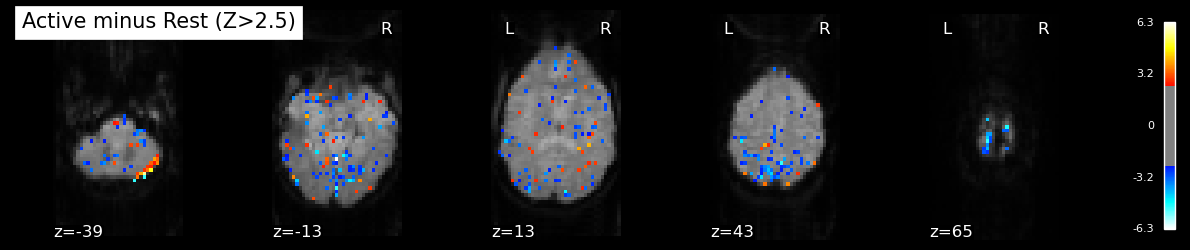

In [82]:
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
mean_img_ = mean_img(fmri_data),
plot_stat_map(z_map, bg_img=mean_img_[0], threshold=2.5,
              display_mode='z', cut_coords=5, black_bg=True,
              title='Active minus Rest (Z>2.5)')
plt.show()

## Corrected Z-Score contrast analysis

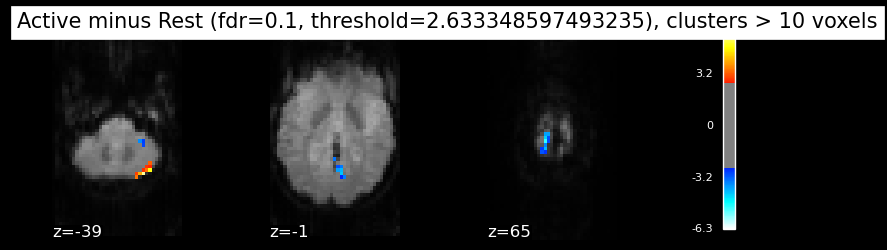

In [83]:
from nilearn.glm import threshold_stats_img

cluster_size = 10 # Fill me with the number of voxels for a cluster to be kept
fdr_rate = 0.1 # Fill me with the fdr rate to use!

# Here, we apply the FDR correction + threshold
clean_map, threshold = threshold_stats_img(z_map, alpha=fdr_rate, height_control='fdr', cluster_threshold=cluster_size)

# And this is just to plot here!
plot_stat_map(clean_map, bg_img=mean_img_[0], threshold=threshold,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Active minus Rest (fdr={}, threshold={}), clusters > {} voxels'.format(fdr_rate, threshold, cluster_size))
plt.show()